In [1]:
import fastai
from fastai import *
from fastai.vision import *

In [2]:
path = URLs.BIWI_SAMPLE

In [3]:
path

'http://files.fast.ai/data/examples/biwi_sample'

In [4]:
root = Path("F:\\data\\fastai")

In [5]:
dest = root/"biwi_sample"
fname = root/"biwi_sample.tar.gz"

In [6]:
path = untar_data(path,dest=dest,fname = fname)

In [7]:
path.ls()

[WindowsPath('F:/data/fastai/biwi_sample/centers.pkl'),
 WindowsPath('F:/data/fastai/biwi_sample/images')]

In [8]:
path = URLs.BIWI_HEAD_POSE
path

'https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose'

In [9]:
dest = root/"biwi_head_pose"
fname = root/"biwi_head_pose.tar.gz"

In [10]:
path = untar_data(path,dest=dest,fname = fname)

In [11]:
path.ls()

[WindowsPath('F:/data/fastai/biwi_head_pose/01'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/02'),
 WindowsPath('F:/data/fastai/biwi_head_pose/02.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/03'),
 WindowsPath('F:/data/fastai/biwi_head_pose/03.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/04'),
 WindowsPath('F:/data/fastai/biwi_head_pose/04.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/05'),
 WindowsPath('F:/data/fastai/biwi_head_pose/05.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/06'),
 WindowsPath('F:/data/fastai/biwi_head_pose/06.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/07'),
 WindowsPath('F:/data/fastai/biwi_head_pose/07.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/08'),
 WindowsPath('F:/data/fastai/biwi_head_pose/08.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/09'),
 WindowsPath('F:/data/fastai/biwi_head_pose/09.obj'),
 WindowsPath('F:/data/fastai/biwi_head_pose/10'),
 WindowsPath('

In [12]:
img_01 = path/'01'
img_01.ls()

[WindowsPath('F:/data/fastai/biwi_head_pose/01/depth.cal'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00003_pose.txt'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00003_rgb.jpg'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00004_pose.txt'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00004_rgb.jpg'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00005_pose.txt'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00005_rgb.jpg'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00006_pose.txt'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00006_rgb.jpg'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00007_pose.txt'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00007_rgb.jpg'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00008_pose.txt'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00008_rgb.jpg'),
 WindowsPath('F:/data/fastai/biwi_head_pose/01/frame_00009_pose.txt'),
 WindowsPath('F:/data/f

In [13]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

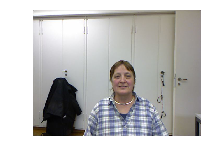

In [14]:
img = open_image(img_01/"frame_00003_rgb.jpg")
img.show()

In [15]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

In [16]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [17]:
fname = path/"01/frame_00014_rgb.jpg"

In [18]:
get_ctr(fname)

tensor([262.8563, 350.6919])

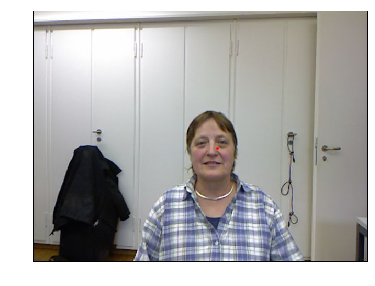

In [19]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

### create dataset

In [20]:
data = PointsItemList.from_folder(path)

In [21]:
data = data.split_by_valid_func(lambda x:x.parent.name == '13')

In [22]:
data = data.label_from_func(get_ctr)

In [23]:
data = data.transform(get_transforms(),tfm_y = True,size=(120,160))

In [24]:
data = data.databunch(no_check=True)

In [25]:
data = data.normalize(imagenet_stats)

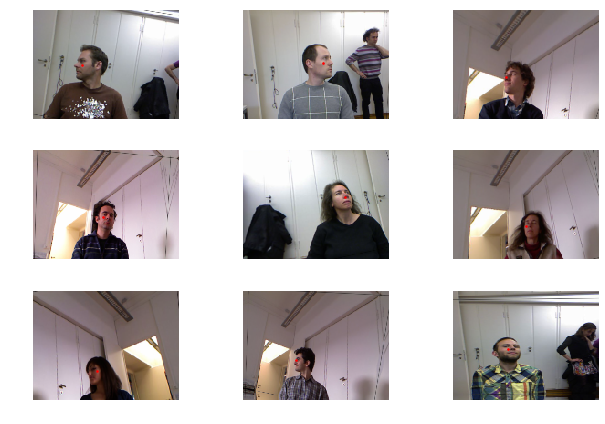

In [27]:
data.show_batch(3,figsize=(9,6))

#### train

In [28]:
model = create_cnn(data,models.resnet18)

In [29]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


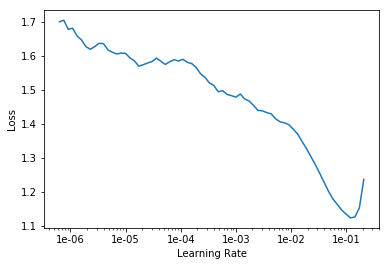

In [30]:
model.recorder.plot()

In [31]:
lr = 2e-2

In [32]:
model.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss
1,0.057483,0.032492
2,0.021457,0.002576
3,0.010311,0.004874
4,0.006768,0.000889
5,0.005104,0.001050


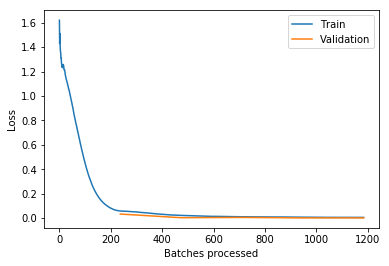

In [34]:
model.recorder.plot_losses()

In [35]:
path

WindowsPath('F:/data/fastai/biwi_head_pose')

In [36]:
model.save(path/"stage-reset-18-1")

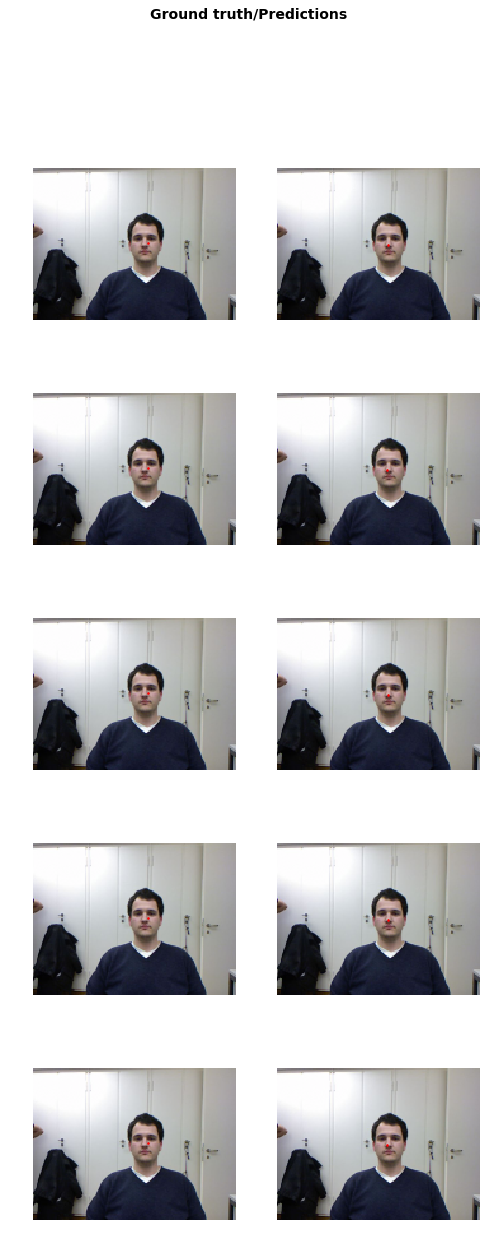

In [37]:
model.show_results()

## Data augmentation

In [40]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160), padding_mode='zeros')
        .databunch().normalize(imagenet_stats)
       )

In [45]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is

In [46]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={'row_pct': 0.6407706690316582, 'col_pct': 0.98419596803043, 'padding_mode': 'reflection'}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.4, 0.4)}, p=1.0, resolved={'magnitude': tensor([-0.2535,  0.3720,  0.2554, -0.3165]), 'invert': False}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-20, 20)}, p=1.0, resolved={'degrees': 6.307140439692944}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.5)}, p=1.0, resolved={'row_pct': 0.8348219819283755, 'col_pct': 0.7470814665556509, 'scale': 1.3096665317863223}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.25

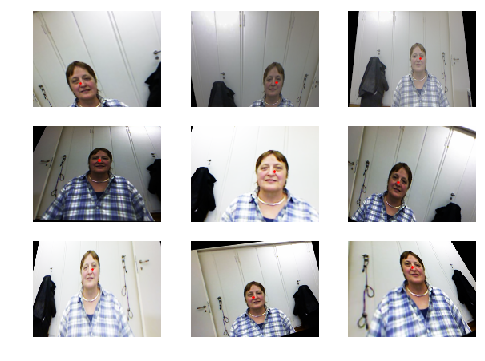

In [41]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

In [42]:
leaner = create_cnn(data,models.resnet18)

In [43]:
leaner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Traceback (most recent call last):
  File "E:\Anaconda3_5_0_0\envs\fastai\lib\site-packages\torch\utils\data\dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "f:\workspace\python\fastai\fastai\torch_core.py", line 105, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "E:\Anaconda3_5_0_0\envs\fastai\lib\site-packages\torch\utils\data\dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "E:\Anaconda3_5_0_0\envs\fastai\lib\site-packages\torch\utils\data\dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "E:\Anaconda3_5_0_0\envs\fastai\lib\site-packages\torch\utils\data\dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 1 and 0 in dimension 1 at c:\a\w\1\s\tmp_conda_3.6_091443\conda\conda-bld\pytorch_1544087948354\work\aten\src\th\generic/THTensorMoreMath.cpp:1333


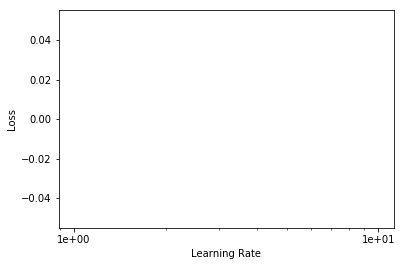

In [44]:
leaner.recorder.plot()